In [1]:
!pip install python-box

In [2]:
import math 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action = 'ignore')
torch.set_printoptions(sci_mode = True)

In [3]:
import pickle

In [4]:
os.getcwd()

'/Linux/Data/recommendation/vae_cf_pytorch'

In [5]:
config = {
    'data_path' : '/Linux/Data/recommendation/vae_cf_pytorch',
    'p_dims' : [200, 600],
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    'valid_samples' : 10,
    'seed' : 4141,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,
    'lr' : 0.001,
    'batch_size' : 250,
    'num_epochs' : 100,
    'num_workers' : 2
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
config = Box(config)

# 데이터 전처리

In [6]:
raw_ratings = pd.read_csv(os.path.join(config.data_path, 'ratings.csv'))

In [7]:
user_item_ratings = raw_ratings
item_user_ratings = raw_ratings[['movieId', 'userId', 'rating', 'timestamp']]

In [8]:
raw_ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [9]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = raw_ratings
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['timestamp']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [10]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]
        
    def __len__(self):
        return self.num_user
    def __getitem__(self, idx):
        user = self.users[idx]
        return torch.LongTensor([user])

# 모델

## Multi-VAE

In [12]:
class MultiVAE_user_item(nn.Module):

    def __init__(self, p_dims, q_dims, dropout_rate = 0.5):
        super(MultiVAE_user_item, self).__init__()
#        self.q1_dims = q1_dims
        self.q1_dims = p_dims[::-1]

        temp_q1_dims = self.q1_dims[:-1] + [self.q1_dims[-1] * 2]

        self.q1_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q1_dims[:-1], temp_q1_dims[1:])])
        
#        self.p_dims = p_dims
        self.q2_dims = q_dims[::-1]
        
        temp_q2_dims = self.q2_dims[:-1] + [self.q2_dims[-1] * 2]
        
        self.q2_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q2_dims[:-1], temp_q2_dims[1:])])
        
        

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input, loss = False):
        mu_u, logvar_u = self.encode_user(input)
        z_u = self.reparameterize(mu_u, logvar_u)
        
        input_t = input.T
        mu_i, logvar_i = self.encode_item(input_t)
        z_i = self.reparameterize(mu_i, logvar_i)
        
        h = torch.matmul(z_u, z_i.T)
        
        if loss:
            return h, mu_u, logvar_u, mu_i, logvar_i
        else:
            return h
    
    def encode_user(self, input):
        h_u = F.normalize(input)
        h_u = self.drop(h_u)

        for i, layer in enumerate(self.q1_layers):
            h_u = layer(h_u)
            if i != len(self.q1_layers) - 1:
                h_u = F.tanh(h_u)
            else:
                mu_u = h_u[:, :self.q1_dims[-1]]
                logvar_u = h_u[:, self.q1_dims[-1]:]
        return mu_u, logvar_u
    
    def encode_item(self, input):
        h_i = F.normalize(input)
        h_i = self.drop(h_i)

        for i, layer in enumerate(self.q2_layers):
            h_i = layer(h_i)
            if i != len(self.q2_layers) - 1:
                h_i = F.tanh(h_i)
            else:
                mu_i = h_i[:, :self.q2_dims[-1]]
                logvar_i = h_i[:, self.q2_dims[-1]:]
        return mu_i, logvar_i
    

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)

            return eps.mul(std).add_(mu)
        else:
            return mu
    
#     def decode(self, z):
#         h = z
#         for i, layer in enumerate(self.p_layers):
#             h = layer(h)
#             if i != len(self.p_layers) - 1:
#                 h = F.tanh(h)
#         return h

    def init_weights(self):
        for layer in self.q1_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.q2_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

# 학습함수

In [29]:
class LossFunc2(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc2, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu_u = None, logvar_u = None, mu_i = None, logvar_i = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
            
        
        if self.model_type == 'VAE':
            KLD1 = -0.5 * torch.mean(torch.sum(1 + logvar_u - mu_u.pow(2) - logvar_u.exp(), dim=1))
            KLD2 = -0.5 * torch.mean(torch.sum(1 + logvar_i - mu_i.pow(2) - logvar_i.exp(), dim=1))
            loss = loss + anneal * (KLD1 + KLD2)
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial1 = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        multinomial2 = -torch.mean(torch.sum(F.log_softmax(recon_x.T, 1) * x.T, -1))
        return multinomial1 + multinomial2

In [35]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit


def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)

        if criterion.model_type == 'VAE':
            anneal = min(config.anneal_cap, 1. * update_count / config.total_anneal_steps)
            update_count += 1
#             recon_mat, mu, logvar = model(mat, loss = True)
            recon_mat, mu_u, logvar_u, mu_i, logvar_i = model(mat, loss = True)
            
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat, mu_u = mu_u, logvar_u = logvar_u, mu_i = mu_i, logvar_i = logvar_i, anneal = anneal)

        else:
            recon_mat = model(mat)
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

# 학습

In [15]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [16]:
ae_dataset = AEDataSet(
        num_user = make_matrix_data_set.num_user)

In [17]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    drop_last = True
    )

In [18]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}

## Multi-VAE

In [37]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
model = MultiVAE_user_item(
    p_dims = config.p_dims + [make_matrix_data_set.num_item],
    q_dims = config.p_dims + [250], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc2(loss_type = 'Multinomial', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [ ]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 1392.15095| NDCG@10: 0.08544| HIT@10: 0.07381
Epoch:   2| Train loss: 1125.44497| NDCG@10: 0.08481| HIT@10: 0.07245
Epoch:   3| Train loss: 1115.77918| NDCG@10: 0.08465| HIT@10: 0.07283
Epoch:   4| Train loss: 1115.57491| NDCG@10: 0.08492| HIT@10: 0.07301
Epoch:   5| Train loss: 1115.30039| NDCG@10: 0.08553| HIT@10: 0.07379
Epoch:   6| Train loss: 1115.88246| NDCG@10: 0.08539| HIT@10: 0.07348
Epoch:   7| Train loss: 1115.41756| NDCG@10: 0.08560| HIT@10: 0.07354
Epoch:   8| Train loss: 1114.02734| NDCG@10: 0.08517| HIT@10: 0.07307
Epoch:   9| Train loss: 1112.54297| NDCG@10: 0.08517| HIT@10: 0.07326
Epoch:  10| Train loss: 1110.98508| NDCG@10: 0.08374| HIT@10: 0.07198
Epoch:  11| Train loss: 1110.08546| NDCG@10: 0.08522| HIT@10: 0.07326
Epoch:  12| Train loss: 1109.59123| NDCG@10: 0.08479| HIT@10: 0.07294
Epoch:  13| Train loss: 1109.75408| NDCG@10: 0.08447| HIT@10: 0.07265
Epoch:  14| Train loss: 1108.82817| NDCG@10: 0.08455| HIT@10: 0.07253
Epoch:  15| Train lo

In [41]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}

In [42]:
loss_dict['batch500'] = loss_list
ndcg_dict['batch500'] = ndcg_list
hit_dict['batch500'] = hit_list

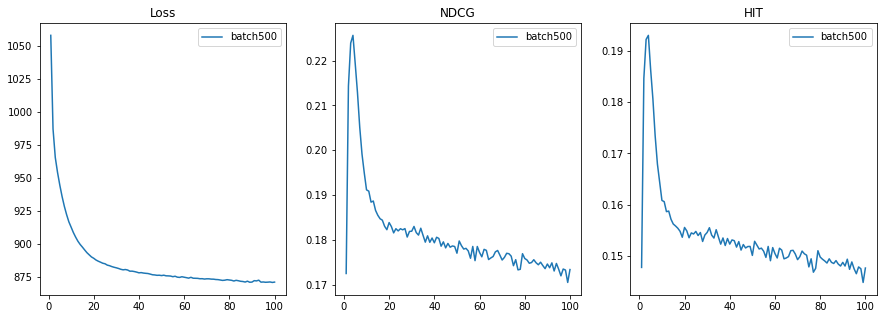

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

for k in loss_dict.keys():
    ax[0].plot(epochs, loss_dict[k], label = k)
ax[0].set_title('Loss')
ax[0].legend()

for k in ndcg_dict.keys():
    ax[1].plot(epochs, ndcg_dict[k], label = k)
ax[1].set_title('NDCG')
ax[1].legend()

for k in hit_dict.keys():
    ax[2].plot(epochs, hit_dict[k], label = k)
ax[2].set_title('HIT')
ax[2].legend()
plt.show()